In [40]:
import pandas as pd
from metar import Metar
import numpy as np
from IOfuncs import *
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')

In [2]:
def make_ml_data_row(taf_time, station, lat, lon, metar_path, glamp_path, hrrr_path, delay_hours = 2):
    if isinstance(metar_path, str):
        metar_path = read_metar(metar_path)
    metarDF = pd.DataFrame()
    glampDF = pd.DataFrame()
    hrrrDF = pd.DataFrame()    
    
    #right now hardcoded to look at metars for 2 hours before TAF due and then predictions after
    for time in range(-6, -delay_hours, 1):
        metar_at_time = get_metar_at_time(taf_time + dt.timedelta(hours = time), metar_path).T
        metarDF[f'metar {time}'] = metar_at_time
    
    work_time = dt.timedelta(hours=-delay_hours)
    glamp_data = get_glamp_at_time(taf_time + work_time, glamp_path, station, download=True)
    hrrr_data = get_hrrr_at_time(taf_time + work_time, hrrr_path, lat, lon, download=True)
    glamp_synoptic_offset = (taf_time.hour - delay_hours) % 6 - 1
    for time in range(-delay_hours, 7, 1):
        glampDF[f'glamp {time}'] = glamp_data.iloc[time + delay_hours + glamp_synoptic_offset]
        hrrrDF[f'hrrr {time}'] = hrrr_data.iloc[time + delay_hours]    
        
    
    df = pd.concat([metarDF, glampDF, hrrrDF])
    df.drop(['ftime', 'ftime_utc', 'model', 'runtime', 'runtime_utc', 'station', 'metar', 'peak_wind_time', 'valid', 'Unnamed: 0'], inplace=True)

    v = df.unstack().to_frame().sort_index(level=1).T
    v.columns = v.columns.map('_'.join)

    final = v.dropna(axis = 1)
    
    return final

In [3]:
taf_time = dt.datetime(year = 2021, month = 8, day = 21, hour = 18, minute = 16)

In [4]:
make_ml_data_row(taf_time, 'kbos', 42.3656, -71.0096, 'Data/BOS.csv', 'Data/GLAMP data/', 'Data/hrrr/')

,hrrr -1_DPT_1000mb,hrrr -2_DPT_1000mb,hrrr 0_DPT_1000mb,hrrr 1_DPT_1000mb,hrrr 2_DPT_1000mb,hrrr 3_DPT_1000mb,hrrr 4_DPT_1000mb,hrrr 5_DPT_1000mb,hrrr 6_DPT_1000mb,hrrr -1_DPT_2m_above_ground,...,glamp 6_wdr,glamp -1_wsp,glamp -2_wsp,glamp 0_wsp,glamp 1_wsp,glamp 2_wsp,glamp 3_wsp,glamp 4_wsp,glamp 5_wsp,glamp 6_wsp
0,292.8,293.5,292.2,292.0,291.8,294.0,293.5,292.2,293.2,293.2,...,90.0,8.0,7.0,9.0,9.0,9.0,9.0,8.0,8.0,7.0


In [5]:
def make_ml_training_data_row(taf_time, station, lat, lon, metar_path, glamp_path, hrrr_path, delay_hours = 2, tplus_hours = 6):
    if isinstance(metar_path, str):
        metar_path = full_metar_list = read_metar(metar_path)
    
    df = make_ml_data_row(taf_time, station, lat, lon, metar_path, glamp_path, hrrr_path, delay_hours = delay_hours)
    
    for i in range(tplus_hours):
        metar_at_time = get_metar_at_time(taf_time + dt.timedelta(hours = i), metar_path)
        vis = metar_at_time['vsby']
        ceiling = find_ceiling_height(metar_at_time['metar'])
        if ceiling is None:
            ceiling = 100000

        if ceiling < 500 or vis < 1:
            conditions = 0
        elif ceiling < 1000 or vis < 3:
            conditions = 1
        elif ceiling < 3000 or vis < 5:
            conditions = 2
        else:
            conditions = 3

        df[f'flight category {i}'] = conditions

    return df

In [6]:
make_ml_training_data_row(taf_time, 'kbos', 42.3656, -71.0096, 'Data/BOS.csv', 'Data/GLAMP data/', 'Data/hrrr/')['flight category 3']

0    3
Name: flight category 3, dtype: int64

In [7]:
def make_ml_training_data_set(start_time, end_time, station, lat, lon, metar_path, glamp_path, hrrr_path, delay_hours = 2, frequency = '5H'):
    training_df = pd.DataFrame()
    time_series = pd.date_range(start_time, end_time, freq = frequency)
    if isinstance(metar_path, str):
        metar_path = read_metar(metar_path)
    for time in tqdm(time_series):
        try:
            training_row = make_ml_training_data_row(time, station, lat, lon, metar_path, glamp_path, hrrr_path, delay_hours = delay_hours)
            training_df = pd.concat([training_df, training_row])
        except FileNotFoundError:
            continue

    training_df = training_df.fillna(-99999)
    return training_df

In [8]:
def data_split(data):
    y_keys = np.asarray([key for key in data if 'flight category' in key])
    X = data.drop(y_keys, axis=1)
    y_list = data[y_keys]
    return X, y_list


In [9]:
start_date = dt.datetime(year = 2021, month = 1, day = 1, hour = 0, minute = 0)
end_date = dt.datetime(year = 2021, month = 6, day = 20, hour = 23, minute = 0)
data = make_ml_training_data_set(start_date, end_date, 'kbos', 42.3656, -71.0096, 'Data/BOS.csv', 'Data/GLAMP data/', 'Data/hrrr/', frequency = 'H')

100%|███████████████████████████████████████████████████████████████████████████████| 4104/4104 [10:26<00:00,  6.55it/s]


In [114]:
(X, y_list) = data_split(data)
y = y_list['flight category 3']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [115]:
classifier_rf = RandomForestClassifier(random_state=42)

In [116]:
%%time
classifier_rf.fit(X_train, y_train)

CPU times: user 1.39 s, sys: 19.8 ms, total: 1.41 s
Wall time: 1.41 s


RandomForestClassifier(random_state=42)

In [117]:
misses = 0 
for val in classifier_rf.predict(X_test) - y_test:
    if val != 0:
        misses += 1
1 - misses / len(X_test)

0.9341463414634146

In [118]:
prob = classifier_rf.predict_proba(X_test)

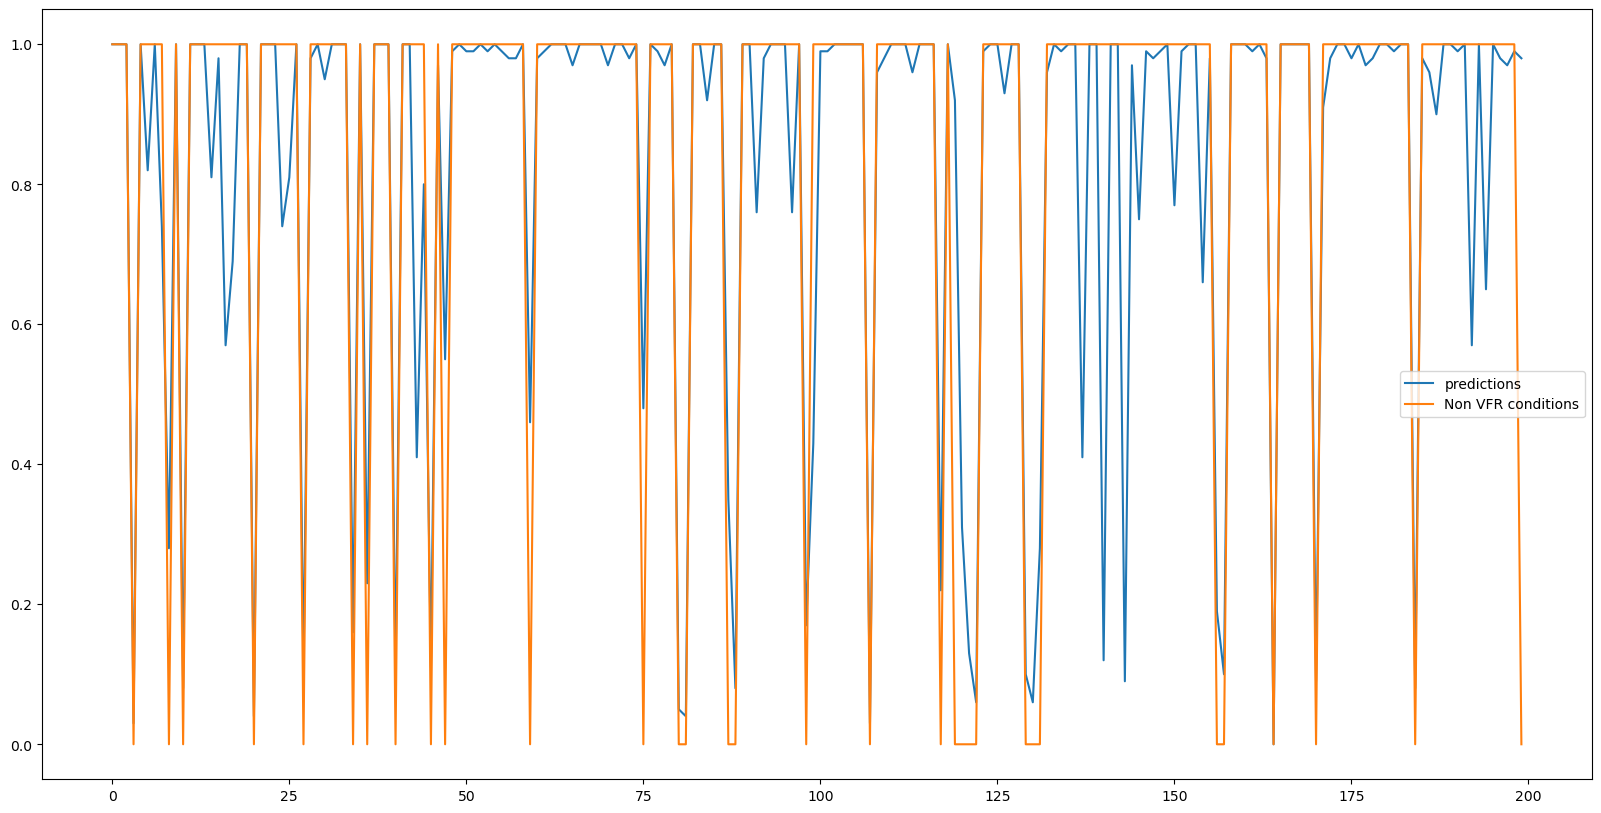

In [119]:
fig, ax = plt.subplots(figsize = (20,10))
k = 200
ax.plot(prob.T[3][:k], label = 'predictions')
ax.plot(np.floor(np.asarray(y_test)[:k] / 3), label = 'Non VFR conditions')
ax.legend()